In [5]:
import pandas as pd
import numpy as np

import tubesml as tml
from tubesml.base import BaseTransformer, self_columns, reset_columns

from source.impute import DfImputer

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

import xgboost as xgb

In [2]:
df_train = pd.read_csv('data/train.csv')
train, test = tml.make_test(df_train, test_size=0.25, random_state=43, strat_feat=['Pclass', 'Sex'])
kfolds = KFold(n_splits=10, random_state=235, shuffle=True)
train_cols = ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24665,24665,0,3,"Jones, Rhett",male,44.0,0,0,25604,25.17,NaN,S
67933,67933,0,3,"Twomey, Paul",male,27.0,0,0,478284,11.53,NaN,S
41148,41148,0,3,"Brady, Amy",female,7.0,1,1,10375,80.13,NaN,S
49460,49460,0,3,"Shealy, William",male,37.0,0,0,C 15695,7.69,NaN,S
69515,69515,0,1,"Kolb, Willie",male,65.0,1,1,23480,77.39,C6991,C


# Baseline

In [6]:
num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', DfImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', DfImputer(strategy='most_frequent', add_indicator=True)), 
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

full_pipe = Pipeline([('proc', proc_pipe), 
                      ('tree', xgb.XGBClassifier(n_estimators=2000, n_jobs=-1, reg_alpha=0.3, learning_rate=0.05,
                                    reg_lambda=1, subsample=0.7, max_depth=4, 
                                    random_state=324,objective='binary:logistic',use_label_encoder=False, eval_metric='logloss'))])

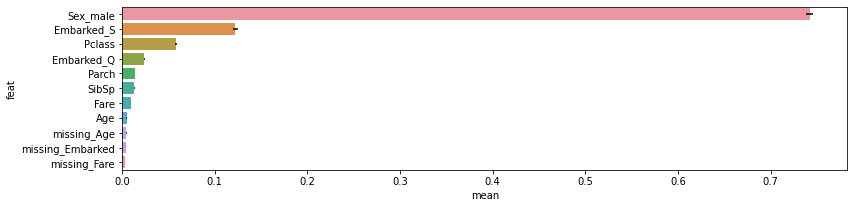

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


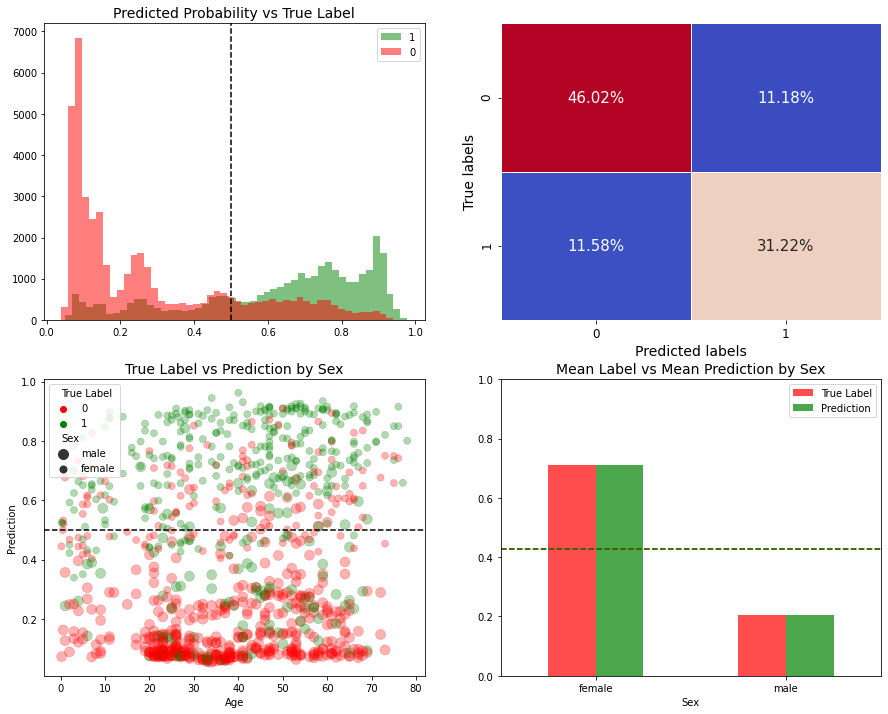

Accuracy score: 	0.7725
AUC ROC: 		0.8432
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     42902
           1       0.74      0.73      0.73     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


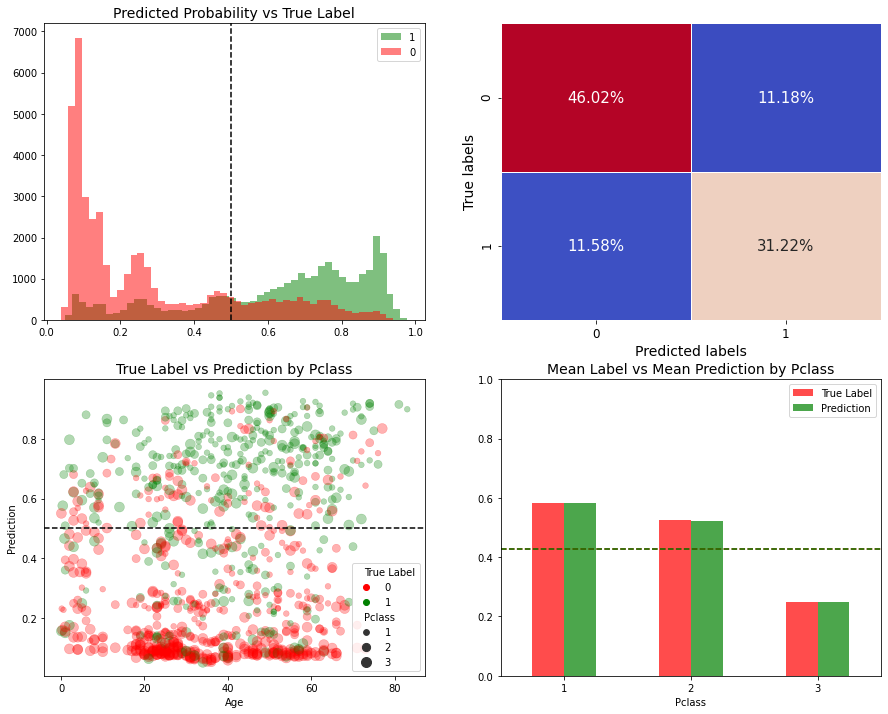

In [7]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, 
                         predict_proba=True, imp_coef=True, early_stopping=100, eval_metric='logloss')
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')

# Interactions

In [9]:
num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', DfImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', DfImputer(strategy='most_frequent', add_indicator=True)), 
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

full_pipe = Pipeline([('proc', proc_pipe), ('int', tml.DfPolynomial()),
                      ('tree', xgb.XGBClassifier(n_estimators=2000, n_jobs=-1, reg_alpha=0.3, learning_rate=0.05,
                                    reg_lambda=1, subsample=0.7, max_depth=4, 
                                    random_state=324,objective='binary:logistic',use_label_encoder=False, eval_metric='logloss'))])

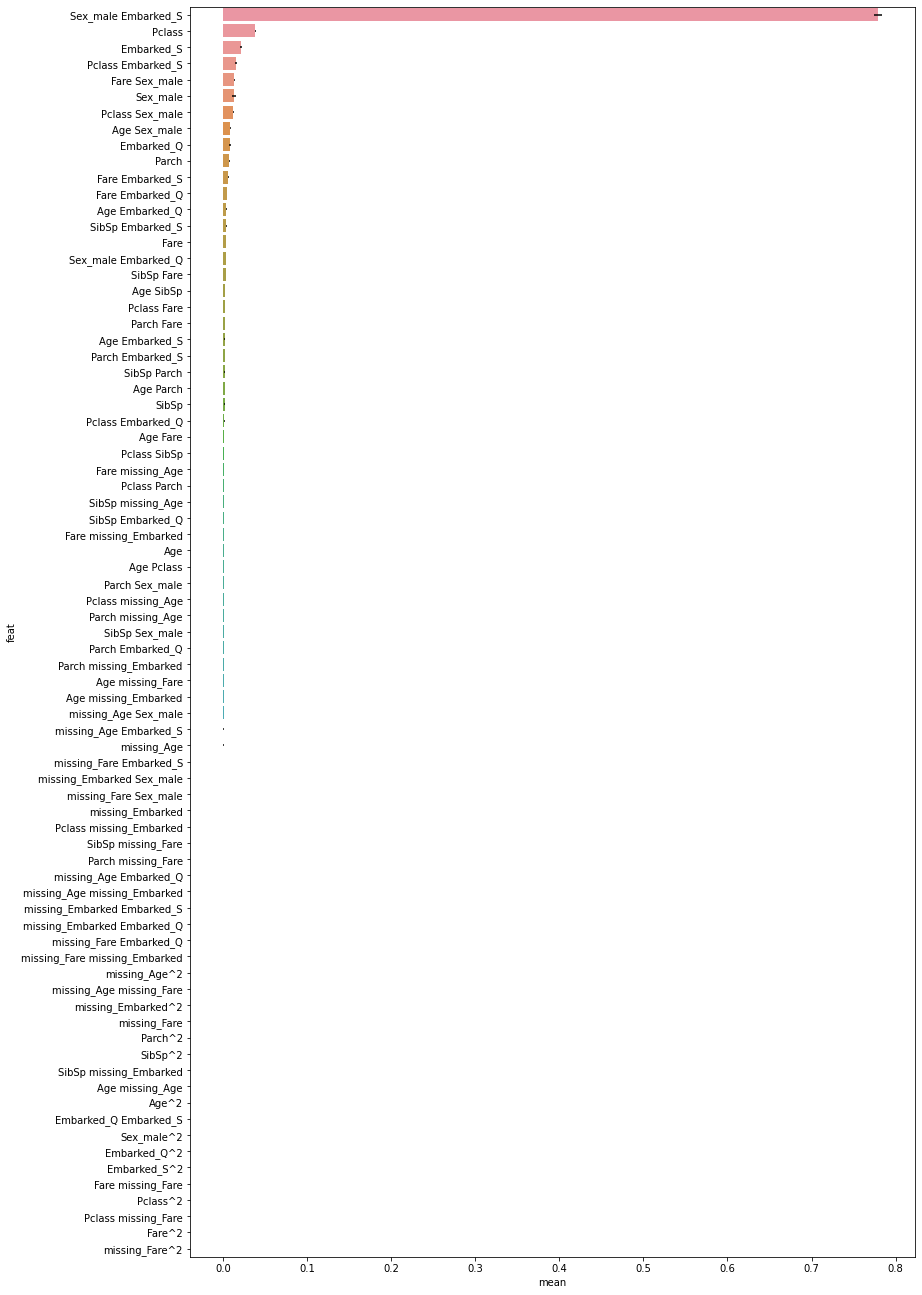

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


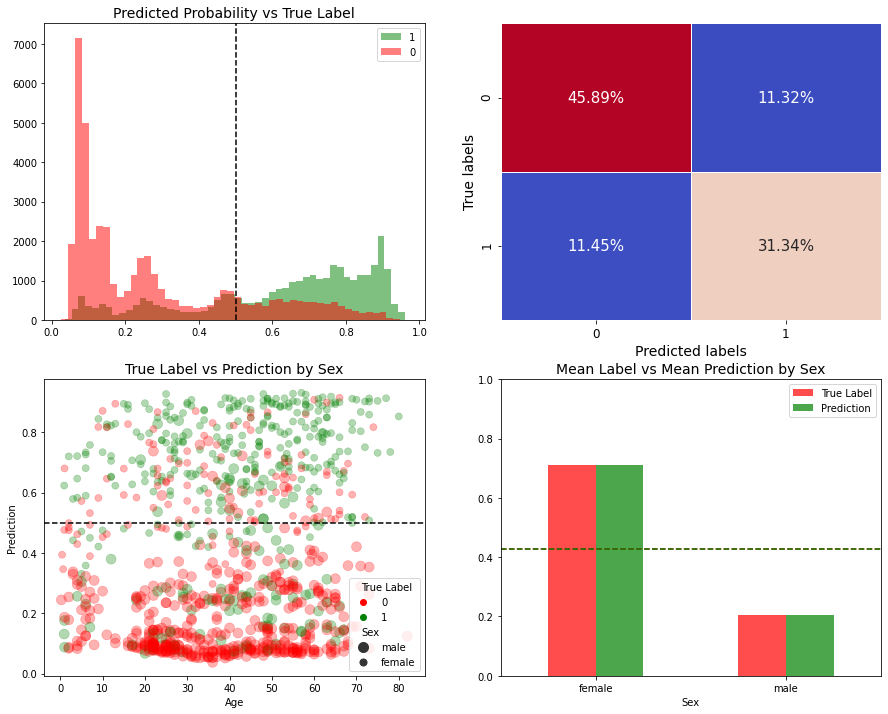

Accuracy score: 	0.7723
AUC ROC: 		0.8433
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     42902
           1       0.73      0.73      0.73     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


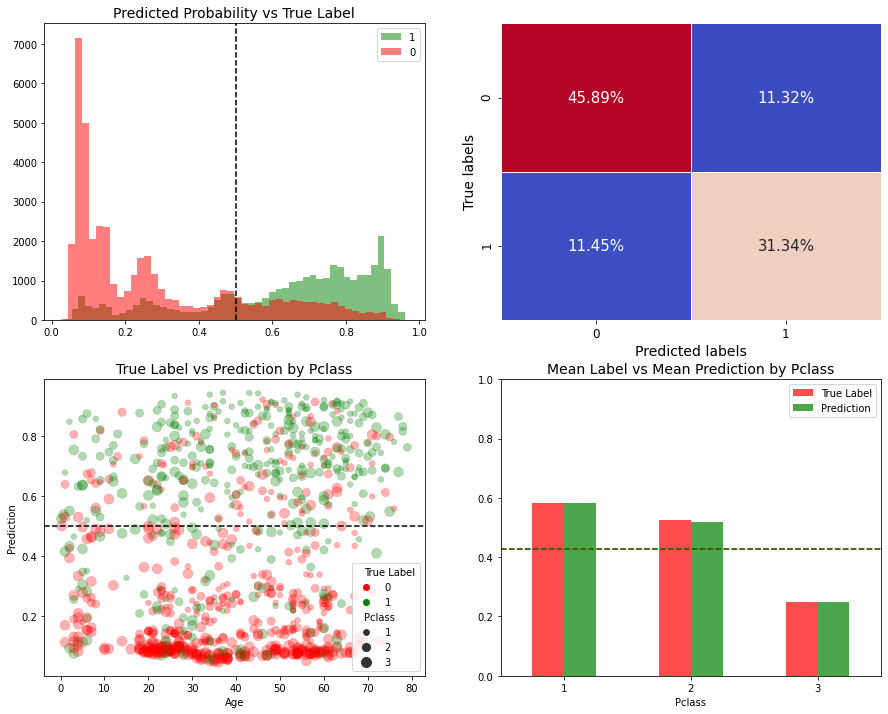

In [10]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, 
                         predict_proba=True, imp_coef=True, early_stopping=100, eval_metric='logloss')
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')

In [11]:
class NumFeats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['fam_size'] = X_tr['Parch'] + X_tr['SibSp'] + 1
        X_tr['famsize_class'] = X_tr['fam_size'] * X_tr['Pclass']
        return X_tr

    
class CatFeats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['Emb_Sex'] = X_tr['Sex'] + '_' + X_tr['Embarked']
        return X_tr
    
    
class IntFeats(BaseTransformer):
    def __init__(self):
        super().__init__()
        
    @self_columns
    def transform(self, X, y=None):
        X_tr = X.copy()
        X_tr['Class_Sex'] = X_tr['Sex_male'] * X_tr['Pclass']
        return X_tr

In [12]:
num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', DfImputer(strategy='median', add_indicator=True)), 
                     ('feats', NumFeats())])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', DfImputer(strategy='most_frequent', add_indicator=True)), 
                     ('feats', CatFeats()),
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

full_pipe = Pipeline([('proc', proc_pipe), ('feats', IntFeats()),
                      ('tree', xgb.XGBClassifier(n_estimators=2000, n_jobs=-1, reg_alpha=0.3, learning_rate=0.05,
                                    reg_lambda=1, subsample=0.7, max_depth=4, 
                                    random_state=324,objective='binary:logistic',use_label_encoder=False, eval_metric='logloss'))])

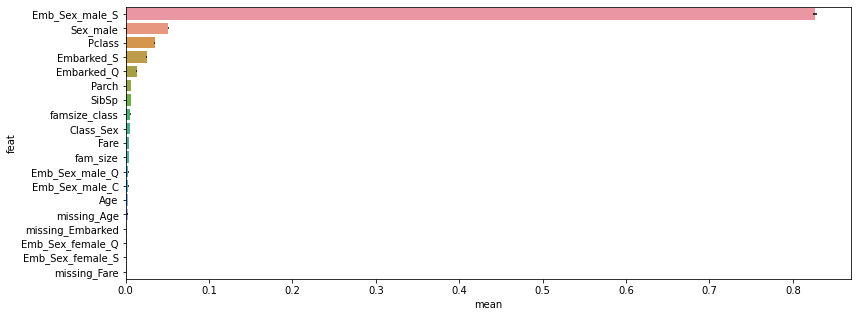

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


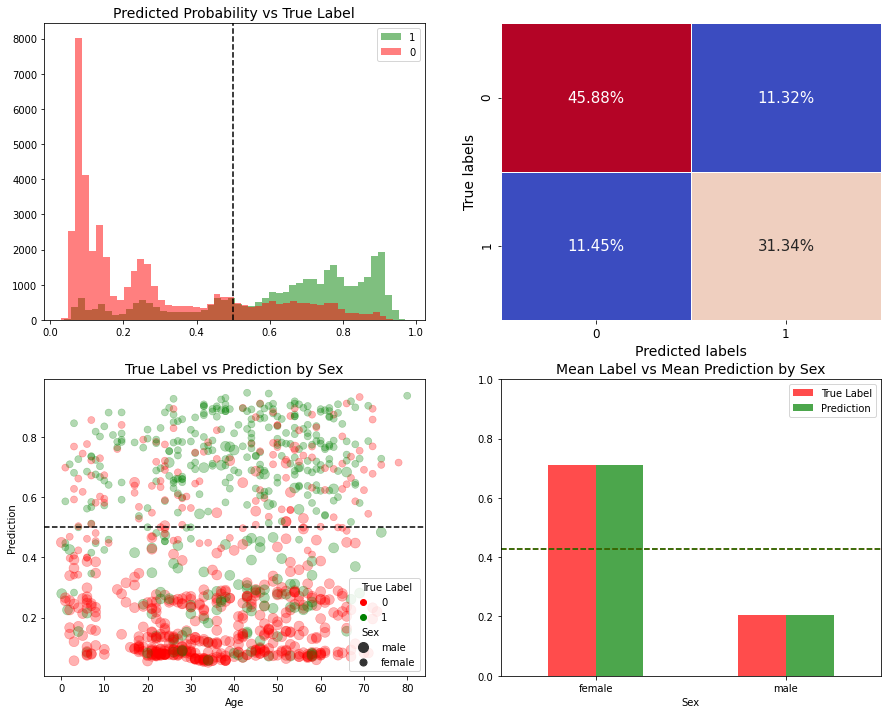

Accuracy score: 	0.7723
AUC ROC: 		0.8437
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     42902
           1       0.73      0.73      0.73     32098

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


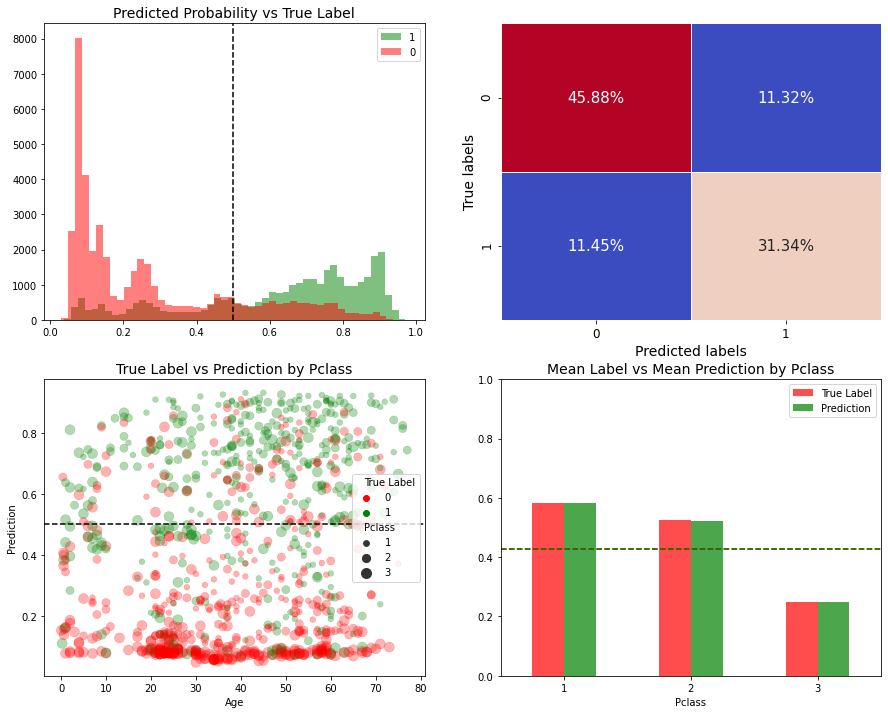

In [13]:
oof, imps = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, 
                         predict_proba=True, imp_coef=True, early_stopping=100, eval_metric='logloss')
tml.plot_feat_imp(imps)
tml.eval_classification(train, train.Survived, oof, plot=1, proba=True, sample=1000, hue_feat='Sex', feat='Age')
tml.plot_classification_probs(train, train.Survived, oof, sample=1000, feat='Age', hue_feat='Pclass')